In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
actScience_11_df = pd.read_csv('../dataframes/actScience_11.csv')

In [3]:
actScience_11_df.head(10)

,studentId,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,...,course_YearbkII9-12,course_Yearbook9-12,course_YrbkIII9-12,school_High School A,school_High School B,school_High School C,school_High School D,iready_math,iready_reading,bbb_literacy
0,45054,False,0.027778,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,0,0,0
1,45054,False,0.027778,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,0,0,0
2,45440,False,0.666667,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
3,45440,False,0.666667,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
4,45440,False,0.666667,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
5,45440,False,0.666667,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
6,45440,False,0.666667,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
7,45953,True,1.111111,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
8,46042,True,1.000000,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,0,0,0
9,46042,True,1.000000,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,0,0,0


Trying PCA

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Initialize scaler and scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(actScience_11_df.drop(['proficient_score', 'studentId', 'is_proficient'], axis=1))

# Perform PCA
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_sum = 0
components = 0

for variance in explained_variance_ratio:
    cumulative_sum += variance
    components += 1
    if cumulative_sum >= 0.80:  # Adjust to your threshold (80%)
        break

print(f"Number of components needed: {components}")
print(f"Cumulative explained variance: {cumulative_sum}")



Number of components needed: 107
Cumulative explained variance: 0.800801047343418


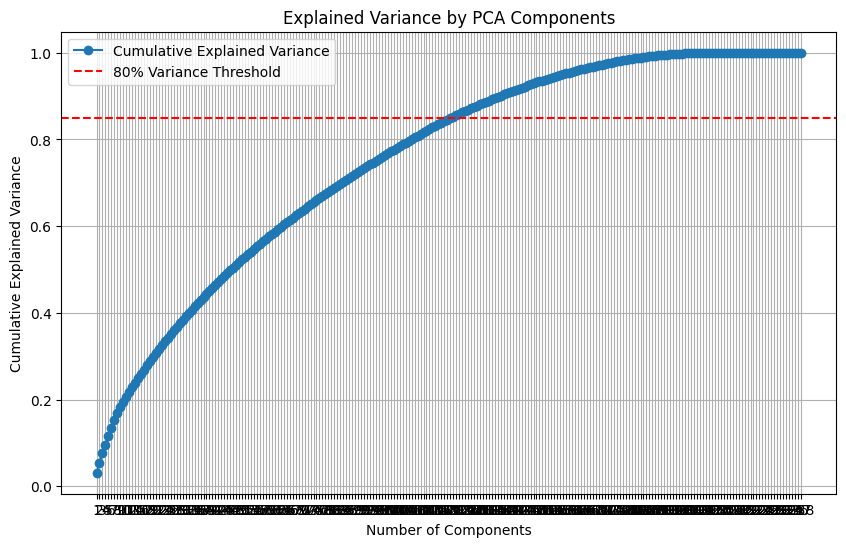

Number of components needed: 107


In [5]:
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--', label='80% Variance Threshold')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid()
plt.show()

# Calculate the number of components needed to explain at least 80% variance
components = np.argmax(cumulative_variance >= 0.80) + 1  # Add 1 to get the count of components
print(f"Number of components needed: {components}")

In [6]:
X_pca = pca.transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
first_108_pcs_df = X_pca_df.iloc[:, :108].copy()
#first_108_pcs_df


In [7]:
print(pca.components_.shape)
print(actScience_11_df.columns)

cols_drop = ['studentId', 'is_proficient', 'proficient_score']
columns_to_drop = [col for col in cols_drop if col in actScience_11_df.columns]
feature_names = actScience_11_df.drop(columns=columns_to_drop).columns

(238, 238)
Index(['studentId', 'is_proficient', 'proficient_score', 'course_ACT Review',
       'course_ACT/WK Rev.', 'course_ACTReview.5C', 'course_AG Communica',
       'course_AIDE-ELEM', 'course_AIDE-LIB', 'course_ALG I B ACCE',
       ...
       'course_YearbkII9-12', 'course_Yearbook9-12', 'course_YrbkIII9-12',
       'school_High School A', 'school_High School B', 'school_High School C',
       'school_High School D', 'iready_math', 'iready_reading',
       'bbb_literacy'],
      dtype='object', length=241)


In [8]:
components = pca.components_[:108]  
# Create a DataFrame for feature loadings
# Rows correspond to features, and columns correspond to principal components
feature_loadings_df = pd.DataFrame(
    components.T,  # Transpose to match features as rows
    columns=[f'PC{i+1}' for i in range(components.shape[0])],  # PC1, PC2, ..., PC108
    index= feature_names  # Feature names
)

# Initialize a list to store the top features across all principal components
all_top_features = []

# For each principal component, find the top features
for pc in feature_loadings_df.columns:
    # Get the absolute values of the loadings and sort them
    sorted_features = feature_loadings_df[pc].abs().sort_values(ascending=False)
    # Get the top 5 features for the current principal component (adjustable)
    top_features = sorted_features.head(5).index.tolist()
    # Add the component and its top features to the list
    for feature in top_features:
        all_top_features.append((pc, feature))

# Create a DataFrame to view all top features for each principal component
top_features_df = pd.DataFrame(all_top_features, columns=['Principal Component', 'Top Feature'])

# Display the DataFrame
print(top_features_df)

    Principal Component           Top Feature
0                   PC1    course_HEALTH 9-12
1                   PC1     course_DRIVERS ED
2                   PC1  school_High School B
3                   PC1    course_D&TSafetyEd
4                   PC1    course_Health 9-12
..                  ...                   ...
535               PC108     course_Accounting
536               PC108   course_Food Nutritn
537               PC108   course_AlgEnrichmet
538               PC108    course_MARKET PRIN
539               PC108      course_Vocal I 1

[540 rows x 2 columns]


In [9]:
top_features_df.head(18)

,Principal Component,Top Feature
0,PC1,course_HEALTH 9-12
1,PC1,course_DRIVERS ED
2,PC1,school_High School B
3,PC1,course_D&TSafetyEd
4,PC1,course_Health 9-12
5,PC2,course_Physical Sci
6,PC2,course_English Gr10
7,PC2,course_Algebra I B
8,PC2,course_USHis I G10
9,PC2,course_US His-1877


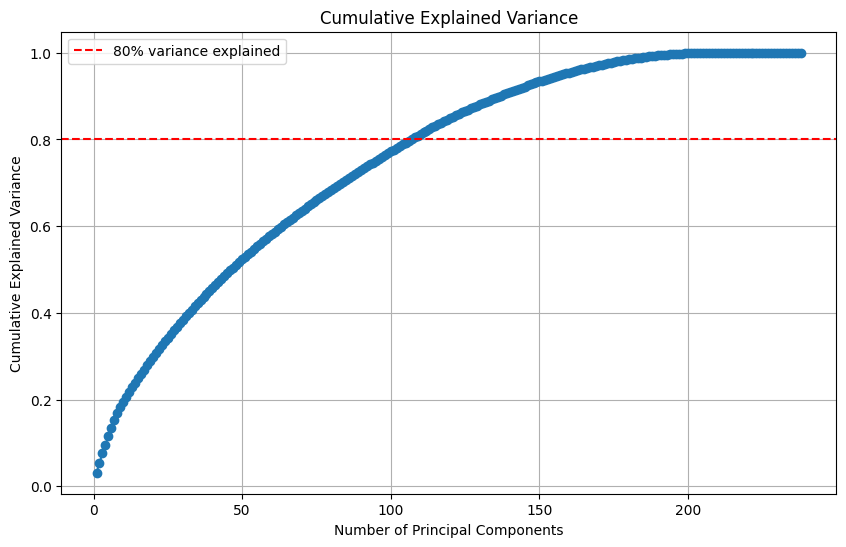

In [10]:
# Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance explained')  # Adjust threshold as needed
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

Training

In [11]:
X = first_108_pcs_df  # PCA-transformed features
y = actScience_11_df['proficient_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
print(X_train.shape)

(2064, 108)


In [12]:
#possible hyperparameters
'''
max_depth_values= [8,12,25,32]
min_samples_leaf_values = [4,5,8,10]
param_grid = {'max_depth' : list(max_depth_values), 'min_samples_leaf' : list(min_samples_leaf_values)}


#Grid Search to find the best hyperparameters 
print("Running Grid Search")
dt_regressor = DecisionTreeRegressor()

# will have a 3-fold cross validation 
dt_grid = GridSearchCV(dt_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
dt_grid_search = dt_grid.fit(X_train, y_train)

print("Done")
dt_best_params = dt_grid_search.best_params_

dt_best_params
'''
#{'max_depth': 32, 'min_samples_leaf': 8}

'\nmax_depth_values= [8,12,25,32]\nmin_samples_leaf_values = [4,5,8,10]\nparam_grid = {\'max_depth\' : list(max_depth_values), \'min_samples_leaf\' : list(min_samples_leaf_values)}\n\n\n#Grid Search to find the best hyperparameters \nprint("Running Grid Search")\ndt_regressor = DecisionTreeRegressor()\n\n# will have a 3-fold cross validation \ndt_grid = GridSearchCV(dt_regressor, param_grid, cv=3, scoring=\'neg_root_mean_squared_error\')\ndt_grid_search = dt_grid.fit(X_train, y_train)\n\nprint("Done")\ndt_best_params = dt_grid_search.best_params_\n\ndt_best_params\n'

In [13]:
dt_model = DecisionTreeRegressor(max_depth=32, min_samples_leaf=8)
dt_model.fit(X_train,y_train)

#testing model on the X_test
y_dt_pred = dt_model.predict(X_test)
dt_rmse = mean_squared_error(y_test,y_dt_pred,squared=False)
dt_r2 = r2_score(y_test,y_dt_pred)

#trying to get f1 and accuracy score 
threshold = 1
y_pred_bool = y_dt_pred >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse))
print('[DT] R2: {0}'.format(dt_r2))

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.93      0.78       282
        True       0.84      0.46      0.60       234

    accuracy                           0.72       516
   macro avg       0.76      0.70      0.69       516
weighted avg       0.75      0.72      0.70       516

[DT] Root Mean Squared Error: 0.2115857377462214
[DT] R2: 0.34406920298911625


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
micro_f1 = f1_score(y_test_bool, y_pred_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7170542635658915


no PCA

In [15]:
print(actScience_11_df.dtypes)

studentId                 int64
is_proficient              bool
proficient_score        float64
course_ACT Review          bool
course_ACT/WK Rev.         bool
                         ...   
school_High School C       bool
school_High School D       bool
iready_math               int64
iready_reading            int64
bbb_literacy              int64
Length: 241, dtype: object


In [16]:
#changing all bools to ints 0 and 1 for the model
actScience_11_df[actScience_11_df.select_dtypes(include=['bool']).columns] = actScience_11_df.select_dtypes(include=['bool']).astype(int)
actScience_11_df.dtypes

studentId                 int64
is_proficient             int64
proficient_score        float64
course_ACT Review         int64
course_ACT/WK Rev.        int64
                         ...   
school_High School C      int64
school_High School D      int64
iready_math               int64
iready_reading            int64
bbb_literacy              int64
Length: 241, dtype: object

Training

In [17]:
#Create Training and Test Data
y_Science = actScience_11_df['proficient_score']
X_Science= actScience_11_df.drop(['proficient_score','is_proficient', 'studentId'], axis=1)
print("Number of examples: " + str(X_Science.shape[0]))

X_train_Science,X_test_Science, y_train_Science,y_test_Science = train_test_split(X_Science,y_Science, test_size=0.20,stratify = actScience_11_df['is_proficient'],random_state=123)
print(X_train_Science.shape)
print(X_test_Science.shape)

#possible hyperparameters
max_depth_values_Science = [8,12,25,32]
min_samples_leaf_values_Science = [4,5,8,10]
param_grid_Science = {'max_depth' : list(max_depth_values_Science), 'min_samples_leaf' : list(min_samples_leaf_values_Science)}

Number of examples: 2580
(2064, 238)
(516, 238)


In [18]:
#Grid Search to find the best hyperparameters 
print("Running Grid Search")
dt_regressorRead = DecisionTreeRegressor()

# will have a 3-fold cross validation 
dt_grid_Science= GridSearchCV(dt_regressorRead, param_grid_Science, cv=3, scoring='neg_root_mean_squared_error')
dt_grid_search_Science = dt_grid_Science.fit(X_train_Science, y_train_Science)

print("Done")
dt_best_params_Science = dt_grid_search_Science.best_params_

dt_best_params_Science
#{'max_depth': 12, 'min_samples_leaf': 4}

Running Grid Search
Done


{'max_depth': 12, 'min_samples_leaf': 4}

Metrics

In [19]:
dt_model_Science= DecisionTreeRegressor(max_depth=12, min_samples_leaf=4)
dt_model_Science.fit(X_train_Science,y_train_Science)

#testing model on the X_test
y_dt_pred_Science = dt_model_Science.predict(X_test_Science)
dt_rmse_Science = mean_squared_error(y_test_Science,y_dt_pred_Science,squared=False)
dt_r2_Science = r2_score(y_test_Science,y_dt_pred_Science)

#trying to get f1 and accuracy score 
threshold = 1
y_pred_Science_bool = y_dt_pred_Science >= threshold
y_test_Science_bool = y_test_Science>= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_Science_bool, y_pred_Science_bool))

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse_Science))
print('[DT] R2: {0}'.format(dt_r2_Science))

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.92      0.77       293
        True       0.78      0.39      0.52       223

    accuracy                           0.69       516
   macro avg       0.72      0.65      0.64       516
weighted avg       0.71      0.69      0.66       516

[DT] Root Mean Squared Error: 0.2264760557592268
[DT] R2: 0.27986608469888685


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
#looking at the micro score
micro_f1_2 = f1_score(y_test_Science_bool, y_pred_Science_bool, average='micro')

print("Micro F1 Score:", micro_f1_2)

Micro F1 Score: 0.687984496124031


Feature Importance

In [21]:
importances = dt_model_Science.feature_importances_
feature_names = X_train_Science.columns

# Combine names and importances, and sort
importance_df_Science = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df_Science= importance_df_Science.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df_Science)

                  Feature  Importance
58    course_ChemistryAdv    0.414116
84      course_Enviro Sci    0.097023
29     course_Algebra I B    0.055305
40    course_BandConcer.5    0.041733
23    course_Alg Esntls B    0.027396
..                    ...         ...
230    course_YrbkIII9-12    0.000000
233  school_High School C    0.000000
232  school_High School B    0.000000
231  school_High School A    0.000000
237          bbb_literacy    0.000000

[238 rows x 2 columns]


In [22]:
importance_df_Science.head(10)

,Feature,Importance
58,course_ChemistryAdv,0.414116
84,course_Enviro Sci,0.097023
29,course_Algebra I B,0.055305
40,course_BandConcer.5,0.041733
23,course_Alg Esntls B,0.027396
156,course_Phy Sci Adv,0.024391
76,course_Eng Gr10 Adv,0.023094
208,course_VarFBI,0.021303
123,course_Intermed Agr,0.021121
198,course_USHis I Adv,0.018834


SHAP